### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import learning_curve, train_test_split

from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [5]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='r2',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.title(f'Learning curves ({type(estimator).__name__})')
    plt.xlabel('Training examples')
    plt.ylabel('Score')     
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Пути к директориям и файлам

In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Загрузка данных

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Feature engineering / Работа с признаками

In [9]:
def feature_engineering(df):
    # Преобразование в фиктивную переменную:
    df['Home Ownership_Home Mortgage'] = (df['Home Ownership'] == 'Home Mortgage').astype('bool')
    df['Home Ownership_Rent'] = (df['Home Ownership'] == 'Rent').astype('bool')
    df['Home Ownership_Own Home'] = (df['Home Ownership'] == 'Own Home').astype('bool')
    df['Home Ownership_Home Mortgage'] = (df['Home Ownership'] == 'Have Mortgage').astype('bool')
    df.drop(['Home Ownership'], axis=1, inplace=True)
        
    # Заполнение пропусков медианой.
    Annual_Income_median = df['Annual Income'].median()
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = Annual_Income_median
        
    # Преобразование из категориальной переменной в числовую
    df.loc[df['Years in current job'] == '< 1 year', 'Years in current job'] = 0
    df.loc[df['Years in current job'] == '1 year', 'Years in current job'] = 1
    df.loc[df['Years in current job'] == '2 years', 'Years in current job'] = 2
    df.loc[df['Years in current job'] == '3 years', 'Years in current job'] = 3
    df.loc[df['Years in current job'] == '4 years', 'Years in current job'] = 4
    df.loc[df['Years in current job'] == '5 years', 'Years in current job'] = 5
    df.loc[df['Years in current job'] == '6 years', 'Years in current job'] = 6
    df.loc[df['Years in current job'] == '7 years', 'Years in current job'] = 7
    df.loc[df['Years in current job'] == '8 years', 'Years in current job'] = 8
    df.loc[df['Years in current job'] == '9 years', 'Years in current job'] = 9
    df.loc[df['Years in current job'] == '10+ years', 'Years in current job'] = 10
      
    df['Years in current job'] = df['Years in current job'].astype(float)

    # Заполнение пропусков значениями, которые встречаются наиболее часто(мода)
    Years_in_current_job_mode = df['Years in current job'].mode()[0]
    df.loc[df['Years in current job'].isnull(), 'Years in current job'] = Years_in_current_job_mode
    
    # Уменьшение количества выбросов
    df.loc[df['Tax Liens'] > 5, 'Tax Liens'] = 5
    df.loc[df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = 8
    
    # Уменьшение количества выбросов
    df.loc[df['Number of Credit Problems'] > 5, 'Number of Credit Problems'] = 5
        
    # Создание колонки - «Были проблемы с кредитом», 1 - да, 0 - нет
    df['Were Credit Problems'] = (df['Number of Credit Problems'] >0).astype('bool')

    # Заполнение пропусков значениями
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 17
    df.loc[ df['Months since last delinquent'] > 65, 'Months since last delinquent'] = 17
    
    # Заполнение пропусков значениями
    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

    # Преобразование в фиктивную переменную
    df['Purpose_small business'] = (df['Purpose'] == 'small business').astype('bool')
    df['Purpose_business loan'] = (df['Purpose'] == 'business loan').astype('bool')
    df['Purpose_medical bills'] = (df['Purpose'] == 'medical bills').astype('bool')
    df['Purpose_other'] = (df['Purpose'] == 'other').astype('bool')
    df['Purpose_debt consolidation'] = (df['Purpose'] == 'debt consolidation').astype('bool')
    df['Purpose_take a trip'] = (df['Purpose'] == 'take a trip').astype('bool')
    df['Purpose_wedding'] = (df['Purpose'] == 'wedding').astype('bool')
    df['Purpose_buy house'] = (df['Purpose'] == 'buy house').astype('bool')
    df['Purpose_home improvements'] = (df['Purpose'] == 'home improvements').astype('bool')
    df['Purpose_buy a car'] = (df['Purpose'] == 'buy a car').astype('bool')
    df['Purpose_vacation'] = (df['Purpose'] == 'vacation').astype('bool')
    df['Purpose_major purchase'] = (df['Purpose'] == 'major purchase').astype('bool')
    df['Purpose_moving'] = (df['Purpose'] == 'moving').astype('bool')
    df['Purpose_educational expenses'] = (df['Purpose'] == 'educational expenses').astype('bool')
    
    # Уменьшение количества выбросов - удаление малозначимых признаков
    df.drop(['Purpose'], axis=1, inplace=True)
    
    df['Long Term'] = (df['Term'] == 'Long Term')
    df.drop(['Term'], axis=1, inplace=True)
  
    # Уменьшение количества выбросов, заполнение фиксированным значением  
    df.loc[df['Current Loan Amount'] > 800000, 'Current Loan Amount'] = 0
    
    
    for col in ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance']:
        max_col_value = df[col].quantile(q=0.75) + (df[col].quantile(q=0.75) - df[col].quantile(q=0.25))*1.5
        min_col_value = df[col].quantile(q=0.25) - (df[col].quantile(q=0.75) - df[col].quantile(q=0.25))*1.5
        df.loc[(df[col] > max_col_value) | (df[col] < min_col_value), col] = df[col].mean()
        

    # Заполнение пропусков медианой
    Credit_Score_median = df['Credit Score'].median()
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = Credit_Score_median
    
    # Построение новых признаков
    df['Loan_income_ratio'] = df['Current Loan Amount'] / df['Annual Income']
    df['Balance_income_ratio'] = df['Current Credit Balance'] / df['Annual Income']
    df['Debt_income_ratio'] = df['Monthly Debt'] / (df['Annual Income'] / 12) * 100

In [10]:
feature_engineering(train_df)
feature_engineering(test_df)

In [11]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Current Loan Amount           7500 non-null   float64
 11  Current Credit Balance        7500 non-null   float64
 12  Monthly Debt                  7500 non-null   float64
 13  Cre

### Корреляция признаков

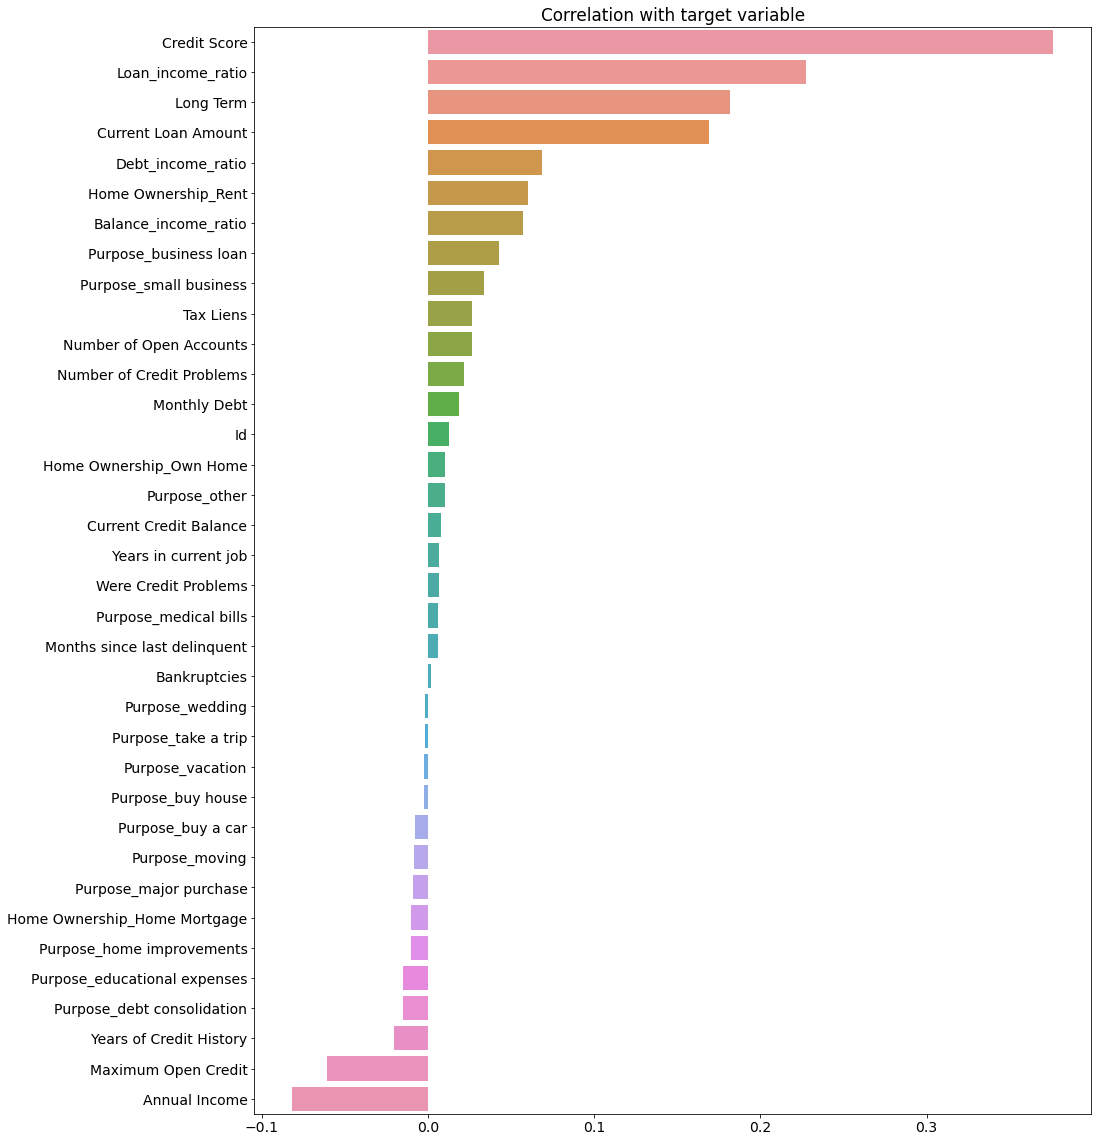

In [12]:
TARGET_NAME = 'Credit Default'

corr_with_target = train_df.corr()[TARGET_NAME].sort_values(ascending=False)[1:]

plt.figure(figsize=(15, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

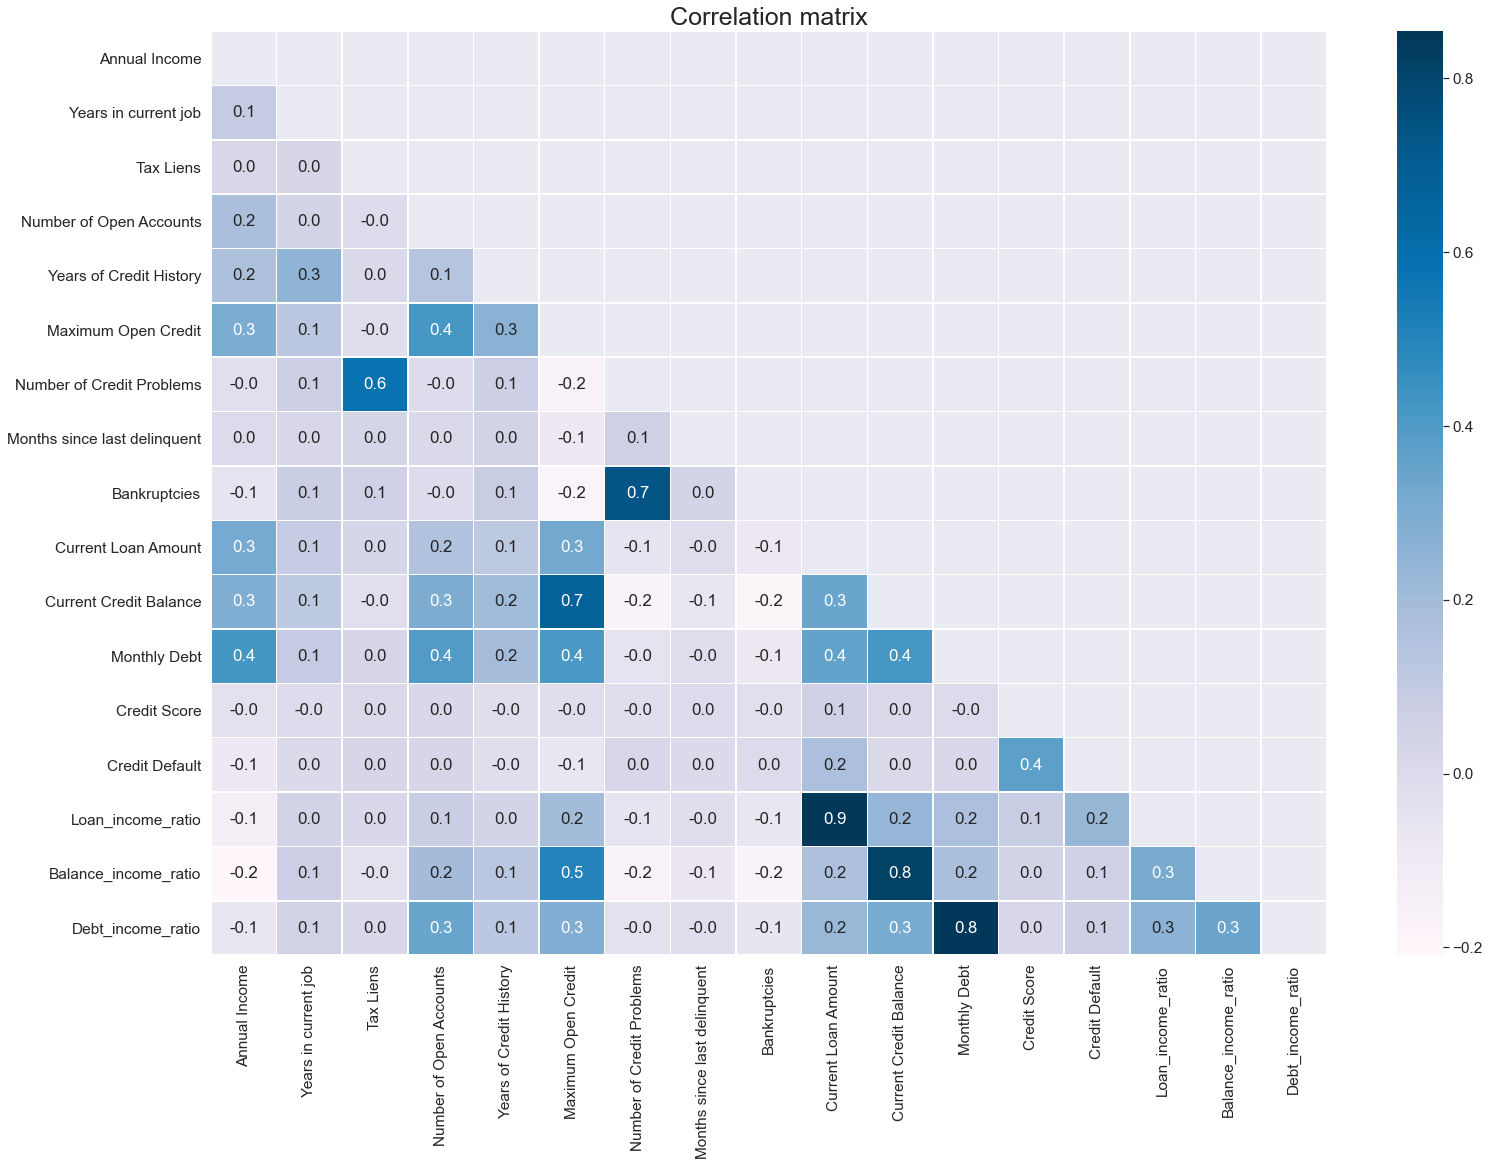

In [13]:
# Correlation Matrix
df_num_features = train_df.select_dtypes(include = ['float64', 'int64'])
num_features = pd.DataFrame(df_num_features)
num_features.drop('Id', axis=1, inplace=True)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix', fontsize=25)
plt.show()

### Подготовка признаков

In [14]:
X = pd.get_dummies(train_df)
X.drop('Credit Default', axis=1, inplace=True)
X.drop('Id', axis=1, inplace=True)
y = train_df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.24, random_state=15)

### Балансировка по целевому классу

In [15]:
def balance_df_by_target(train_df, y, portion_of_target_class=0.5, random_state=15):
    counts_0 = (train_df[TARGET_NAME] == 0).sum()
    counts_1 = (train_df[TARGET_NAME] == 1).sum()
    minor_class = 0 if (counts_0 < counts_1) else 1
    if portion_of_target_class > (counts_1 / (counts_1 + counts_0)):
        disbalance = int(counts_0 / (1-portion_of_target_class) - counts_1 - counts_0)
    else:
        disbalance = int(counts_1 / (1-portion_of_target_class) - counts_1 - counts_0)
    sample = train_df[train_df[y] == minor_class].sample(n=disbalance, replace=True, random_state=random_state)

    return pd.concat([sample, train_df], axis=0)

In [16]:
df_balanced = balance_df_by_target(pd.concat([X_train, y_train], axis=1), TARGET_NAME, 0.50, 2)
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Создание и обучение модели

In [17]:
%%time
model_rfc = RandomForestClassifier(n_estimators=825, max_depth=8, random_state=15, max_features=7)      # max public score
# model_rfc = RandomForestClassifier(n_estimators=855, max_depth=13, random_state=1, max_features=3)    # balance precision and recall
model_rfc.fit(X_train, y_train)
y_pred_train  = model_rfc.predict(X_train)
y_pred_test = model_rfc.predict(X_test)
# print('TRAIN - RandomForestClassifier\n\n' + classification_report(y_train, y_pred_train))
print('TEST - RandomForestClassifier(Kaggle - 0.56326)\n\n' + classification_report(y_test, y_pred_test))
# print(f'TRAIN - RandomForestClassifier - {f1_score(y_train, y_pred_train)}')
print(f'TEST - RandomForestClassifier - {f1_score(y_test, y_pred_test)}')

TEST - RandomForestClassifier(Kaggle - 0.56032)

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1312
           1       0.48      0.62      0.54       488

    accuracy                           0.72      1800
   macro avg       0.66      0.68      0.67      1800
weighted avg       0.74      0.72      0.73      1800

TEST - RandomForestClassifier - 0.5408805031446541
Wall time: 10.3 s


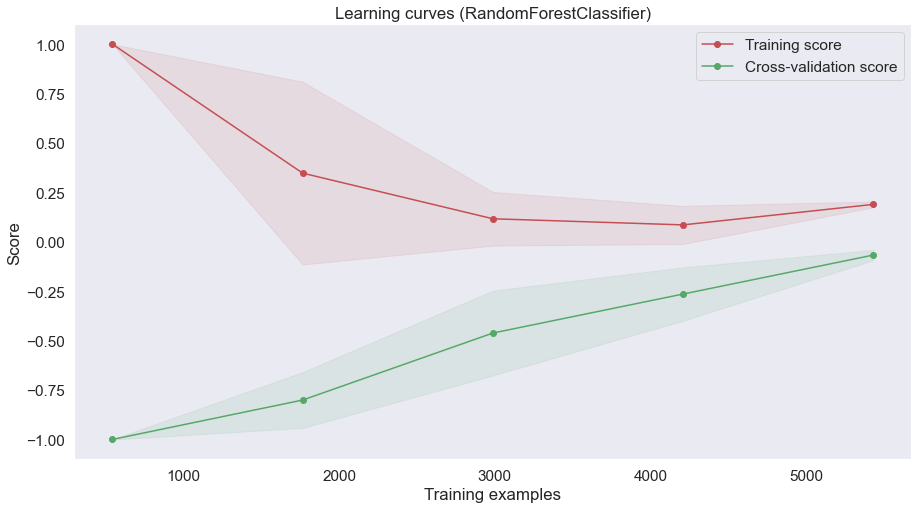

In [18]:
show_learning_curve_plot(model_rfc, X_train, y_train)

<!-- TRAIN

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1374
           1       0.59      0.40      0.48       501

    accuracy                           0.77      1875
   macro avg       0.70      0.65      0.66      1875
weighted avg       0.75      0.77      0.75      1875 -->

### Прогнозирование и сохранение результатов

In [19]:
X_test = pd.get_dummies(test_df)
X_test.drop('Id', axis=1, inplace=True)
test_df['Credit Default'] = model_rfc.predict(X_test)
test_df['Credit Default'] = test_df['Credit Default'].astype('int')
test_df.loc[:, ['Id', 'Credit Default']].to_csv(RES_PATH, index=False, encoding='utf-8')

In [20]:
train_df['Credit Default'].sort_values().unique()

array([0, 1], dtype=int64)

In [21]:
test_df['Credit Default'].sort_values().unique()

array([0, 1])

In [22]:
# from google.colab import files
# files.download(RES_PATH)